# Historical Predictions
This notebook contains the code for the Historical Predictions.

In [ ]:
!pip install world-bank-data==0.1.3

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from drive.MyDrive.lib import estimator_util as eu
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

In [5]:
sns.set_theme()

In [8]:
DATA_PATH = 'drive/MyDrive/data/'
lsms_path = f'{DATA_PATH}/processed/_all_nominal.csv'
cnn_weights_path = f'{DATA_PATH}/weights/weights_all_countries.csv'
FIGS_PATH = 'drive/MyDrive/figs'

In [9]:
complete_df, all_cols = eu.get_data(lsms_path,cnn_weights_path , DATA_PATH)

## All Countries
Historical future and past predictions for all countries.

In [10]:
def all_year_run(complete_df):
    countries = complete_df.groupby(["country"]).groups.keys()
    base_year = []
    year_ = []
    r2 = []
    country_ = []
    for country in countries:
        years = complete_df.loc[complete_df["country"] == country].groupby(["year"]).groups.keys()
        for year in years:
            for x_year in years:
                X_base, y_base = eu.get_features(complete_df, [country], [year], all_cols)
                if year == x_year:
                    r, _, m = eu.run_ridge(X_base, y_base)
                    country_.append(country)
                    base_year.append(year)
                    year_.append(x_year)
                    r2.append(r)
                    continue
                infl = eu.get_inflation_perf(country, year, x_year)
                X, y = eu.get_features(complete_df, [country], [x_year], all_cols, infl=infl)
                n = len(X_base)
                X = StandardScaler().fit_transform(X)
                r, y_hest, m = eu.run_ridge_out(X_base, y_base, X, y, alpha=10000)
                country_.append(country)
                base_year.append(year)
                year_.append(x_year)
                r2.append(r)
    return pd.DataFrame.from_dict({"Country": country_,"Train Year": base_year, "Eval Year": year_, "r2": r2})
        

In [11]:
all_year_run(complete_df)

,Country,Train Year,Eval Year,r2
0,ETH,2013,2013,0.132616
1,ETH,2013,2015,0.140785
2,ETH,2013,2018,0.190638
3,ETH,2015,2013,0.118347
4,ETH,2015,2015,0.159695
5,ETH,2015,2018,0.242817
6,ETH,2018,2013,0.076418
7,ETH,2018,2015,0.109603
8,ETH,2018,2018,0.271679
9,MLI,2014,2014,0.190023


## Leave-one-out

In [12]:
countries = ["ETH","NG","MLI","NER","TZA","UGA","MW"]
for country in countries:
    print(f"======{country}=====")
    years = list(complete_df.loc[complete_df["country"] == country].groupby(["year"]).groups.keys())
    print(years)
    loo = LeaveOneOut()
    X_ = None
    y_ = None
    for year, x_year in loo.split(years):
        for y in year:
            infl = eu.get_inflation_perf(country, 2010, years[y])
            X_base, y_base = eu.get_features(complete_df, [country], [years[y]], all_cols, infl)
            
            if X_ is None:
                X_ = X_base
            else:
                X_ = np.vstack((X_, X_base))
            
            if y_ is None:
                y_ = y_base
            else:
                y_ = np.append(y_, y_base)

        infl = eu.get_inflation_perf(country, 2010, years[x_year[0]])
        X, y = eu.get_features(complete_df, [country], [years[x_year[0]]], all_cols, infl=infl)
        X_ = StandardScaler().fit_transform(X_)
        X = StandardScaler().fit_transform(X)
        r, y_hest, m = eu.run_ridge_out(X_, y_, X, y, alpha=1000)
        print(f"Predicting: {years[x_year[0]]}")
        print(r)

======ETH=====
[2013, 2015, 2018]
Predicting: 2013
0.14892484555172583
Predicting: 2015
0.308487840801713
Predicting: 2018
0.41792818073571747
======NG=====
[2012, 2015, 2018]
Predicting: 2012
0.05708254786724666
Predicting: 2015
0.4556657206806192
Predicting: 2018
0.5581370956850199
======MLI=====
[2014, 2018]
Predicting: 2014
0.09564663227583434
Predicting: 2018
0.5700761843383352
======NER=====
[2011, 2018]
Predicting: 2011
0.5702143312857897
Predicting: 2018
0.6853091315496112
======TZA=====
[2012, 2014]
Predicting: 2012
0.13328142983337782
Predicting: 2014
0.28924289944033993
======UGA=====
[2009, 2010]
Predicting: 2009
0.20562244806703767
Predicting: 2010
0.35563906507157494
======MW=====
[2016, 2019]
Predicting: 2016
0.48752805642744895
Predicting: 2019
0.5927655102876668


## Pooled Dataset
Predictions for whole dataset. Consumption is scaled to base year 2010.

In [14]:
countries = [["NG"], ["ETH"] ,["TZA"], ["MW"],["NER"],["UGA"], ["MLI"], ["NG", "ETH", "TZA", "MW","MLI","UGA","NER"]]
arr = np.zeros((len(countries),len(countries)))
for i, country in enumerate(countries):
    X, y = eu.get_features_allyears(complete_df, country, all_cols)
    for j, out_country in enumerate(countries):
        X_out, y_out = eu.get_features_allyears(complete_df,out_country, all_cols)
        r, _, _= eu.run_ridge_out(X, y, X_out, y_out)
        arr[i,j] = r

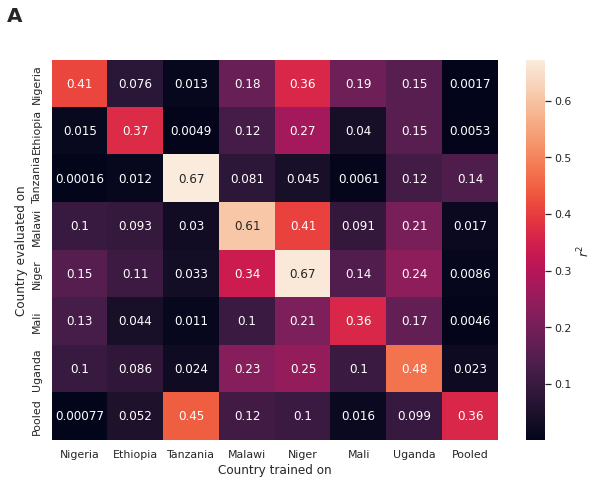

In [21]:
countries = ["Nigeria", "Ethiopia" ,"Tanzania", "Malawi","Niger","Mali","Uganda","Pooled"]
df_cm = pd.DataFrame(arr, index = countries, columns = countries)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cbar_kws={'label': r'$r^2$'})
plt.xlabel("Country trained on")
plt.ylabel("Country evaluated on")
ax = plt.gca()
plt.text(-0.1, 1.1, string.ascii_uppercase[0], size=20, weight='bold', transform=ax.transAxes)
plt.savefig(f"{FIGS_PATH}/cross_country_pooled_timetravel.pdf", dpi=600, bbox_inches="tight")

In [17]:
country = ["NG", "ETH", "TZA", "MW","MLI","NER","UGA"]
X, y = eu.get_features_allyears(complete_df, country, all_cols)
r, _, m = eu.run_ridge(X, y)

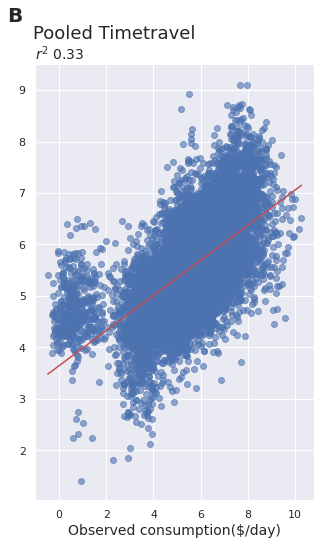

In [22]:
y_hest = m.predict(X)
eu.plot_predictions(y, y_hest, r, "Pooled", "Timetravel", 1)
plt.savefig(f"{FIGS_PATH}/Pooled_timetravel.pdf", dpi=600, bbox_inches="tight")